## **Формулировка А/Б теста**

На лендинг с оформлением дебетовой карты была добавлена информация о дополнительных кэшбеках. 

Необходимо проверить вырастит ли конверсия из переходов на лендинг в оформление дебетовой карты. 

В приложенном файле доступны логи переходов на сайт и последующего оформления карточки за каждый день. 

Нулевая гипотеза $H_0$: $\mu_{test} = \mu_{control}$ <br>
Альтернативная гипотеза $H_1$: $\mu_{test} > \mu_{control}$


## **Импорт библиотек**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats


In [2]:
df = pd.read_csv('data.csv') # Загрузите таблицу в датафрейм

print(df.shape)
print(df.dtypes)
df.head()

(94778, 4)
date         object
id            int64
group        object
converted     int64
dtype: object


,date,id,group,converted
0,2023-08-01,5030836,control,0
1,2023-08-01,5091425,control,0
2,2023-08-01,5106537,control,0
3,2023-08-01,4556522,control,0
4,2023-08-01,4002917,control,0


## **Данные**
- date — дата захода пользователя на лендинг
- id — идентификатор, присвоенный пользователю
- group — группа теста или контроля
- converted – 1, если пользователь оформил карточку и 0, если не оформил

In [3]:
df.drop_duplicates(subset=['id'], inplace=True)
print(df.shape)
print(df[df['group'] == 'control'].shape)
print(df[df['group'] == 'test'].shape)

(94778, 4)
(47330, 4)
(47448, 4)


In [4]:
# отличаются ли конверсии в тесте и в контроле?

group_info = df[['id', 'group', 'converted']].groupby(['group', 'converted']).count().reset_index()
group_info

,group,converted,id
0,control,0,42408
1,control,1,4922
2,test,0,41774
3,test,1,5674


In [5]:
# конверсия в контроле: 
control_seen = group_info[(group_info['group'] == 'control')]['id'].sum()
control_clicked = group_info[(group_info['group'] == 'control') & (group_info['converted'] == 1)]['id'][1]
control_conversion = control_clicked / (control_seen)

# конверсия в тесте: 
test_seen = group_info[(group_info['group'] == 'test')]['id'].sum()
test_clicked = group_info.iloc[3, 2]
test_conversion = test_clicked / test_seen

# отношение конверсий: 
print("Конверсия в контрольной группе:", control_conversion)
print("Конверсия в тестовой группе:", test_conversion)
print("Относительное изменение:", (test_conversion / control_conversion - 1) * 100, "%")

Конверсия в контрольной группе: 0.10399323896049018
Конверсия в тестовой группе: 0.11958354409037261
Относительное изменение: 14.991652616768292 %


Проверим является ли это различие статистически значимым

In [6]:
# сначала используем знание о том, что конверсии распределены биномиально: 
# используйте статистический тест и проинтерпретируйте результаты
# как меняется ваш результат в зависимости от принятого вами уровня значимости?

from scipy.stats import binomtest

alpha = 0.05 # Уровень значимости

binomtest_res = binomtest(test_clicked, test_seen, control_conversion)

print(binomtest_res)

if (binomtest_res.pvalue < alpha):
    print("Различие в конверсиях статистически значимо.")
else:
    print("Различие в конверсиях статистически не значимо.")
    

BinomTestResult(k=5674, n=47448, alternative='two-sided', statistic=0.11958354409037261, pvalue=1.2376571667780677e-27)
Различие в конверсиях статистически значимо.


In [7]:
print(df['date'].nunique())
df['date'].unique()

93


array(['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
       '2023-08-05', '2023-08-06', '2023-08-07', '2023-08-08',
       '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-12',
       '2023-08-13', '2023-08-14', '2023-08-15', '2023-08-16',
       '2023-08-17', '2023-08-18', '2023-08-19', '2023-08-20',
       '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
       '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
       '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
       '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
       '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09',
       '2023-09-10', '2023-09-11', '2023-09-12', '2023-09-13',
       '2023-09-14', '2023-09-15', '2023-09-16', '2023-09-17',
       '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
       '2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25',
       '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29',
       '2023-09-30', '2023-10-01', '2023-10-02', '2023-

In [8]:
# Количество открытых карт, заходов на лендинг и конверсии по дням в тесте и в контроле:

df_group_day_info = pd.pivot_table(data=df, values=['converted'], index=['group', 'date'], aggfunc=['sum','size']).reset_index()
df_group_day_info.columns = df_group_day_info.columns.droplevel(1)
df_group_day_info['conv_rate'] = df_group_day_info['sum'] / df_group_day_info['size']

display(df_group_day_info.head())

,group,date,sum,size,conv_rate
0,control,2023-08-01,45,512,0.087891
1,control,2023-08-02,63,512,0.123047
2,control,2023-08-03,60,547,0.109689
3,control,2023-08-04,56,486,0.115226
4,control,2023-08-05,54,513,0.105263


In [9]:
tmp = []

for date in df_group_day_info['date'].unique():
    if date.split('-')[2] == '01':
        tmp.append(date)

tmp

['2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01']

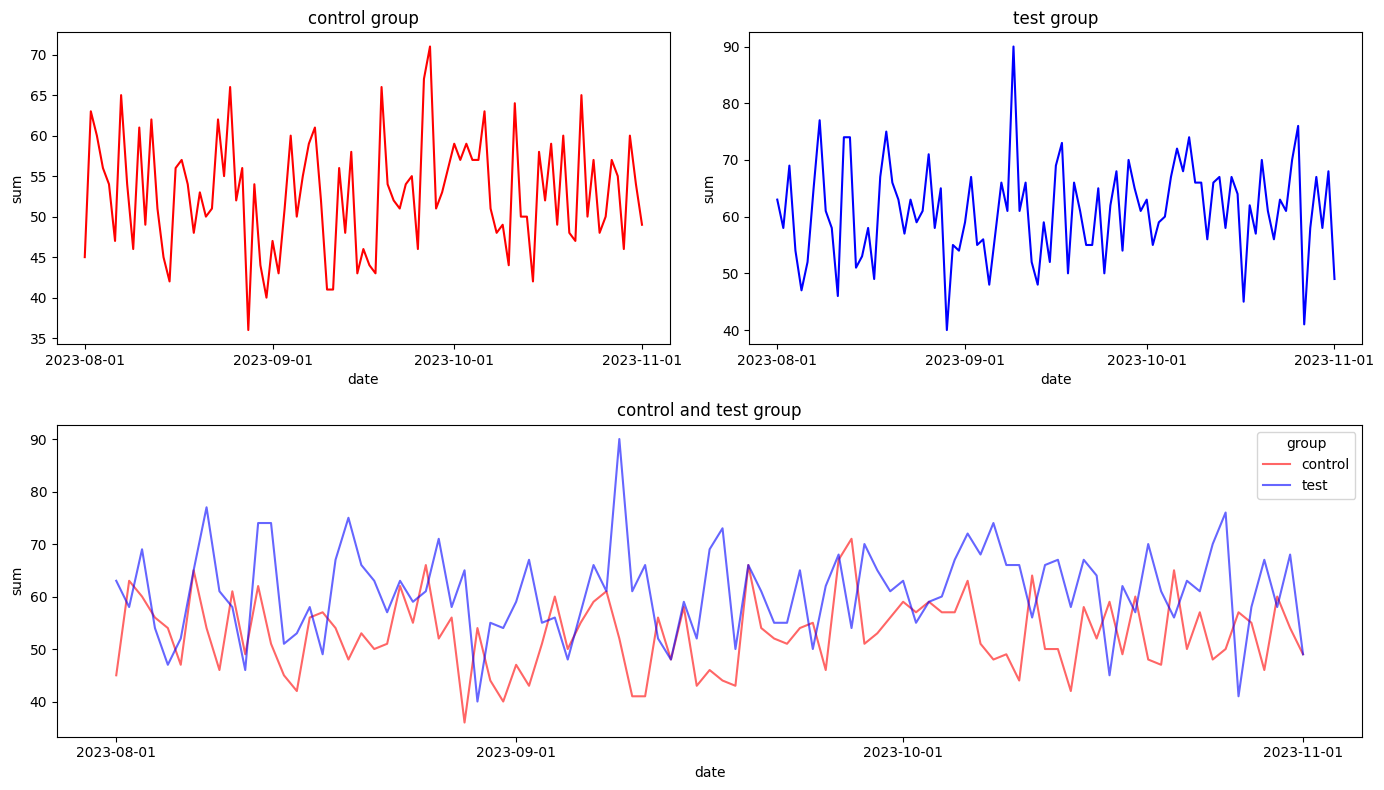

In [10]:
plt.figure(figsize=(14, 8))

grid = GridSpec(2, 2)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1, :])


sns.lineplot(data=df_group_day_info[df_group_day_info['group'] == 'control'], x='date', y='sum', color='red', ax=ax1)
ax1.set_xticks(tmp)
ax1.set_title(label="control group")

sns.lineplot(data=df_group_day_info[df_group_day_info['group'] == 'test'], x='date', y='sum', color='blue', ax=ax2)
ax2.set_xticks(tmp)
ax2.set_title(label="test group")

sns.lineplot(data=df_group_day_info, x='date', y='sum', hue='group', color='blue', ax=ax3, palette=['red', 'blue'], alpha=0.6)
ax3.set_xticks(tmp)
ax3.set_title(label="control and test group")

plt.tight_layout()
plt.show()


(0.0, 0.2)

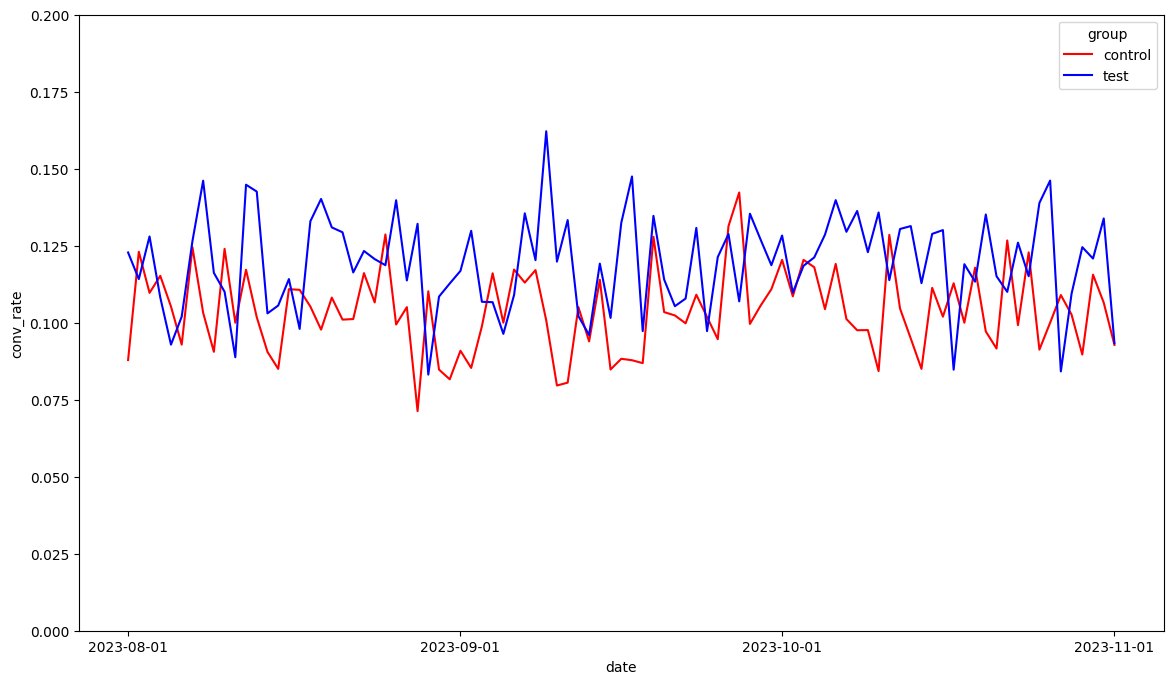

In [11]:
# построим график, отражающий конверсию из посещений в оформленние карт по дням
fig, ax = plt.subplots(figsize=(14 ,8))

sns.lineplot(data=df_group_day_info, x='date', y='conv_rate', hue='group', palette=['red', 'blue'], ax=ax)
ax.set_xticks(tmp)
plt.ylim(0, 0.2)

Распределение количества заходов на лендинг по дням в тесте и в контроле

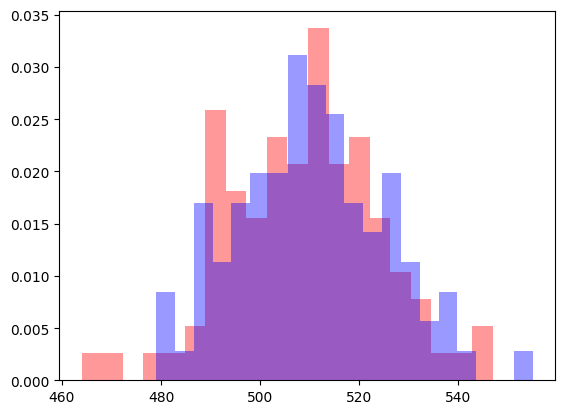

In [12]:
plt.hist(df_group_day_info[df_group_day_info['group'] == 'control']['size'],20,density=True,color='r',alpha=0.4)
plt.hist(df_group_day_info[df_group_day_info['group'] == 'test']['size'],20,density=True,color='b',alpha=0.4)

plt.show()

Распределение количества оформлений дебетовых карт по дням в тесте и в контроле

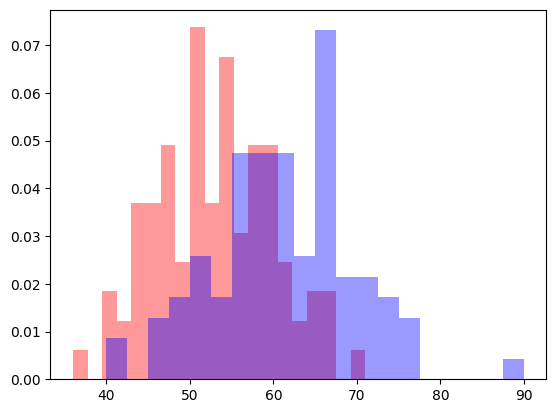

In [13]:
plt.hist(df_group_day_info[df_group_day_info['group'] == 'control']['sum'],20,density=True,color='r',alpha=0.4)
plt.hist(df_group_day_info[df_group_day_info['group'] == 'test']['sum'],20,density=True,color='b',alpha=0.4)

plt.show()

Распределение конверсии по дням в тесте и в контроле

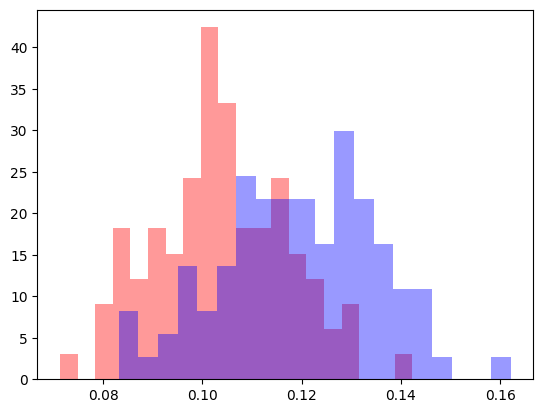

In [14]:
plt.hist(df_group_day_info[df_group_day_info['group'] == 'control']['conv_rate'],20,density=True,color='r',alpha=0.4)
plt.hist(df_group_day_info[df_group_day_info['group'] == 'test']['conv_rate'],20,density=True,color='b',alpha=0.4)

plt.show()

Конверсии распределены нормально. Используем статистический тест `ttest_ind`. Он используется для проверки соответствия средних двух независимых выборок.

In [15]:
from scipy.stats import ttest_ind

alpha = 0.05 # Уровень значимости
ttest_res_conv = ttest_ind(a=df_group_day_info[df_group_day_info['group'] == 'test']['conv_rate'], b=df_group_day_info[df_group_day_info['group'] == 'control']['conv_rate'])

print(ttest_res_conv)

if (ttest_res_conv.pvalue < alpha):
    print("Различие в среднем от конверсий в тесте и в контроле статистически значимо. Отвергаем нулевую гипотезу")
else:
    print("Различие в среднем от конверсий в тесте и в контроле статистически не значимо. Принимаем нулевую гипотезу")

TtestResult(statistic=np.float64(7.209029622736518), pvalue=np.float64(1.4124701519287306e-11), df=np.float64(184.0))
Различие в среднем от конверсий в тесте и в контроле статистически значимо. Отвергаем нулевую гипотезу


Оформления дебетовых карт распределены нормально. Используем статистический тест `ttest_ind`. Он используется для проверки соответствия средних двух независимых выборок.

In [16]:
alpha = 0.05

ttest_res_clicks = ttest_ind(a=df_group_day_info[df_group_day_info['group'] == 'test']['sum'], b=df_group_day_info[df_group_day_info['group'] == 'control']['sum'])
print(ttest_res_clicks)

if (ttest_res_clicks.pvalue < alpha):
    print("Различие в среднем от переходов в офомление в тесте и в контроле статистически значимо.")
else:
    print("Различие в среднем от переходов в офомление в тесте и в контроле статистически не значимо.")

TtestResult(statistic=np.float64(7.048113433738303), pvalue=np.float64(3.529180601649641e-11), df=np.float64(184.0))
Различие в среднем от переходов в офомление в тесте и в контроле статистически значимо.


## **Вывод**

Принимаем альтернативную гипотезу $H_1$. <br>
Добавление информации о дополнительных кэшбеках привело в среднему росту конверсии из переходов на лендинг в оформление дебетовой карты. 